# Portfolio Optimization - Cross-Asset Allocation Strategy
**Competition:** Arbitrage Arena 2025 - Problem Statement 2  
**Participant:** Aman Jaiswal  
**Team Name:** Deep Learners

## Problem Statement
Build a diversified systematic portfolio across equities, indices, and commodities with high Sharpe ratio and low drawdowns using mean-variance optimization.

## Datasets
- **6 Tech Stocks:** Apple, Amazon, Microsoft, Tesla, NVIDIA, Meta
- **1 Index:** NASDAQ-100
- **2 Commodities:** Gold, Silver, Crude Oil
- **2 Cryptocurrencies:** Bitcoin, Ethereum


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


## 1. Data Loading and Initial Exploration
We will load all 12 datasets and examine their structure, date ranges, and quality.


In [7]:
file_paths = {
    'AAPL': 'Apple Stock Price History.csv',
    'AMZN': 'Amazon.com Stock Price History.csv',
    'MSFT': 'Microsoft Stock Price History.csv',
    'TSLA': 'Tesla Stock Price History.csv',
    'NVDA': 'NVIDIA Stock Price History.csv',
    'META': 'Meta Platforms Stock Price History.csv',
    'NASDAQ': 'Nasdaq 100 Historical Data.csv',
    'GOLD': 'Gold Futures Historical Data.csv',
    'SILVER': 'Silver Futures Historical Data.csv',
    'OIL': 'Crude Oil WTI Futures Historical Data.csv',
    'BTC': 'BTC_USD Bitfinex Historical Data.csv',
    'ETH': 'ETH_USD Binance Historical Data.csv'
}

print(f"Total assets to analyze: {len(file_paths)}")
print("\nAsset symbols:", list(file_paths.keys()))


Total assets to analyze: 12

Asset symbols: ['AAPL', 'AMZN', 'MSFT', 'TSLA', 'NVDA', 'META', 'NASDAQ', 'GOLD', 'SILVER', 'OIL', 'BTC', 'ETH']


In [8]:
raw_data = {}

for symbol, filename in file_paths.items():
    try:
        df = pd.read_csv(filename, encoding='utf-8-sig')
        raw_data[symbol] = df
        print(f"✓ {symbol:8s} - Loaded {len(df):,} records")
    except FileNotFoundError:
        print(f"✗ {symbol:8s} - File not found: {filename}")
    except Exception as e:
        print(f"✗ {symbol:8s} - Error: {str(e)}")

print(f"\nSuccessfully loaded {len(raw_data)} out of {len(file_paths)} datasets")


✓ AAPL     - Loaded 5,000 records
✓ AMZN     - Loaded 5,000 records
✓ MSFT     - Loaded 5,000 records
✓ TSLA     - Loaded 3,618 records
✓ NVDA     - Loaded 5,000 records
✓ META     - Loaded 3,143 records
✓ NASDAQ   - Loaded 5,000 records
✓ GOLD     - Loaded 5,000 records
✓ SILVER   - Loaded 5,000 records
✓ OIL      - Loaded 5,000 records
✓ BTC      - Loaded 4,664 records
✓ ETH      - Loaded 2,486 records

Successfully loaded 12 out of 12 datasets


In [9]:
sample_asset = 'AAPL'
df_sample = raw_data[sample_asset]

print(f"Sample dataset structure ({sample_asset}):")
print(f"\nShape: {df_sample.shape[0]} rows × {df_sample.shape[1]} columns")
print(f"\nColumn names:\n{df_sample.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df_sample.head(3))
print(f"\nData types:")
print(df_sample.dtypes)


Sample dataset structure (AAPL):

Shape: 5000 rows × 7 columns

Column names:
['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 3 rows:
         Date   Price    Open    High     Low    Vol. Change %
0  11/11/2024  224.23  225.00  225.70  221.50  42.01M   -1.20%
1  11/08/2024  226.96  227.17  228.66  226.40  38.33M   -0.23%
2  11/07/2024  227.48  224.63  227.88  224.57  42.14M    2.14%

Data types:
Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object


In [10]:
date_ranges = []

for symbol, df in raw_data.items():
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    date_ranges.append({
        'Asset': symbol,
        'Start Date': df['Date'].min(),
        'End Date': df['Date'].max(),
        'Total Days': len(df)
    })

date_df = pd.DataFrame(date_ranges).sort_values('Asset')
print("Date Range Summary for All Assets:")
print(date_df.to_string(index=False))


Date Range Summary for All Assets:
 Asset Start Date   End Date  Total Days
  AAPL 2005-01-03 2024-11-11        5000
  AMZN 2005-01-03 2024-11-12        5000
   BTC 2012-02-02 2024-11-12        4664
   ETH 2018-01-18 2024-11-12        2486
  GOLD 2005-01-03 2024-08-26        5000
  META 2012-05-18 2024-11-12        3143
  MSFT 2005-01-03 2024-11-11        5000
NASDAQ 2005-01-03 2024-11-12        5000
  NVDA 2005-01-03 2024-11-11        5000
   OIL 2005-01-03 2024-05-10        5000
SILVER 2005-01-03 2024-05-27        5000
  TSLA 2010-06-30 2024-11-12        3618


## 2. Data Preprocessing and Cleaning

We need to:
1. Clean price columns (remove commas from numbers)
2. Handle missing values
3. Align all datasets to common date range
4. Create unified price matrix for analysis


In [12]:
def clean_price_column(value):
    """
    Remove commas and convert to float.
    Example: '1,234.56' -> 1234.56
    """
    if isinstance(value, str):
        value = value.replace(',', '')
    return float(value)

cleaned_data = {}

for symbol, df in raw_data.items():
    df_clean = df.copy()
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%m/%d/%Y')

    price_columns = ['Price', 'Open', 'High', 'Low']
    for col in price_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(clean_price_column)

    df_clean = df_clean.sort_values('Date').reset_index(drop=True)
    cleaned_data[symbol] = df_clean

    print(f"✓ {symbol:8s} - Cleaned and sorted by date")

print(f"\n{len(cleaned_data)} datasets cleaned successfully")


✓ AAPL     - Cleaned and sorted by date
✓ AMZN     - Cleaned and sorted by date
✓ MSFT     - Cleaned and sorted by date
✓ TSLA     - Cleaned and sorted by date
✓ NVDA     - Cleaned and sorted by date
✓ META     - Cleaned and sorted by date
✓ NASDAQ   - Cleaned and sorted by date
✓ GOLD     - Cleaned and sorted by date
✓ SILVER   - Cleaned and sorted by date
✓ OIL      - Cleaned and sorted by date
✓ BTC      - Cleaned and sorted by date
✓ ETH      - Cleaned and sorted by date

12 datasets cleaned successfully


In [13]:
print("Missing Values Analysis:\n")

missing_summary = []
for symbol, df in cleaned_data.items():
    missing_count = df.isnull().sum().sum()
    missing_summary.append({
        'Asset': symbol,
        'Total Missing': missing_count,
        'Missing %': f"{(missing_count / (df.shape[0] * df.shape[1]) * 100):.2f}%"
    })

missing_df = pd.DataFrame(missing_summary)
print(missing_df.to_string(index=False))

if missing_df['Total Missing'].sum() == 0:
    print("\n✓ No missing values found - data quality is excellent!")
else:
    print("\n⚠ Missing values detected - will handle in next step")


Missing Values Analysis:

 Asset  Total Missing Missing %
  AAPL              1     0.00%
  AMZN              0     0.00%
  MSFT              0     0.00%
  TSLA              0     0.00%
  NVDA              0     0.00%
  META              0     0.00%
NASDAQ            365     1.04%
  GOLD              3     0.01%
SILVER             29     0.08%
   OIL            127     0.36%
   BTC            660     2.02%
   ETH              1     0.01%

⚠ Missing values detected - will handle in next step


In [14]:
start_dates = [df['Date'].min() for df in cleaned_data.values()]
end_dates = [df['Date'].max() for df in cleaned_data.values()]

common_start = max(start_dates)
common_end = min(end_dates)

total_days = (common_end - common_start).days
trading_years = total_days / 365.25

print("Common Date Range for Analysis:")
print("=" * 50)
print(f"Start Date:     {common_start.strftime('%B %d, %Y')}")
print(f"End Date:       {common_end.strftime('%B %d, %Y')}")
print(f"Total Days:     {total_days:,} days")
print(f"Trading Years:  {trading_years:.2f} years")
print("=" * 50)


Common Date Range for Analysis:
Start Date:     January 18, 2018
End Date:       May 10, 2024
Total Days:     2,304 days
Trading Years:  6.31 years


In [15]:
filtered_data = {}

for symbol, df in cleaned_data.items():
    df_filtered = df[(df['Date'] >= common_start) & (df['Date'] <= common_end)].copy()
    filtered_data[symbol] = df_filtered

    records_before = len(df)
    records_after = len(df_filtered)
    records_removed = records_before - records_after

    print(f"{symbol:8s}: {records_before:,} → {records_after:,} records "
          f"({records_removed:,} removed)")

print(f"\nAll datasets aligned to common period: {common_start.date()} to {common_end.date()}")


AAPL    : 5,000 → 1,589 records (3,411 removed)
AMZN    : 5,000 → 1,589 records (3,411 removed)
MSFT    : 5,000 → 1,589 records (3,411 removed)
TSLA    : 3,618 → 1,589 records (2,029 removed)
NVDA    : 5,000 → 1,589 records (3,411 removed)
META    : 3,143 → 1,589 records (1,554 removed)
NASDAQ  : 5,000 → 1,589 records (3,411 removed)
GOLD    : 5,000 → 1,629 records (3,371 removed)
SILVER  : 5,000 → 1,641 records (3,359 removed)
OIL     : 5,000 → 1,664 records (3,336 removed)
BTC     : 4,664 → 2,305 records (2,359 removed)
ETH     : 2,486 → 2,300 records (186 removed)

All datasets aligned to common period: 2018-01-18 to 2024-05-10


In [16]:
price_data = pd.DataFrame()

for symbol, df in filtered_data.items():
    df_indexed = df.set_index('Date')
    price_data[symbol] = df_indexed['Price']

price_data = price_data.sort_index()

print("Unified Price Matrix Created:")
print(f"Shape: {price_data.shape[0]} trading days × {price_data.shape[1]} assets")
print(f"\nFirst 5 rows:")
print(price_data.head())
print(f"\nLast 5 rows:")
print(price_data.tail())


Unified Price Matrix Created:
Shape: 1589 trading days × 12 assets

First 5 rows:
             AAPL   AMZN   MSFT   TSLA  NVDA    META   NASDAQ    GOLD  SILVER  \
Date                                                                            
2018-01-18  44.81  64.67  90.10  22.97  5.61  179.80  6811.38  1327.2  16.954   
2018-01-19  44.62  64.73  90.00  23.33  5.75  181.29  6834.33  1333.1  17.036   
2018-01-22  44.25  66.37  91.61  23.44  5.84  185.37  6906.28  1331.9  16.989   
2018-01-23  44.26  68.13  91.90  23.52  5.97  189.35  6963.46  1336.7  16.913   
2018-01-24  43.55  67.88  91.82  23.06  5.89  186.55  6919.35  1356.3  17.489   

              OIL      BTC      ETH  
Date                                 
2018-01-18  63.89  11045.0   991.01  
2018-01-19  63.31  11476.0   979.57  
2018-01-22  63.57  10771.0   999.37  
2018-01-23  64.31  10819.0  1042.47  
2018-01-24  65.36  11414.0  1051.95  

Last 5 rows:
              AAPL    AMZN    MSFT    TSLA   NVDA    META    NASDAQ   

In [17]:
missing_before = price_data.isnull().sum().sum()

if missing_before > 0:
    print(f"Missing values detected: {missing_before}")
    print("\nFilling missing values with forward fill method...")
    price_data = price_data.fillna(method='ffill')
    price_data = price_data.fillna(method='bfill')

    missing_after = price_data.isnull().sum().sum()
    print(f"Missing values after filling: {missing_after}")
else:
    print("✓ No missing values - price matrix is complete!")

print(f"\nFinal Price Matrix: {price_data.shape[0]} rows × {price_data.shape[1]} columns")
print(f"Memory usage: {price_data.memory_usage(deep=True).sum() / 1024:.2f} KB")


Missing values detected: 3

Filling missing values with forward fill method...
Missing values after filling: 0

Final Price Matrix: 1589 rows × 12 columns
Memory usage: 161.38 KB


## 3. Calculate Returns and Statistical Properties

We calculate daily returns using two methods:
- **Simple Returns:** (P_t - P_{t-1}) / P_{t-1}
- **Log Returns:** ln(P_t / P_{t-1}) - Better for statistical analysis

For portfolio optimization, we'll use simple returns.


In [19]:
returns = price_data.pct_change().dropna()

log_returns = np.log(price_data / price_data.shift(1)).dropna()

print("Daily Returns Calculated:")
print(f"Shape: {returns.shape[0]} days × {returns.shape[1]} assets")
print(f"\nReturns Summary Statistics:")
print(returns.describe())


Daily Returns Calculated:
Shape: 1588 days × 12 assets

Returns Summary Statistics:
              AAPL         AMZN         MSFT         TSLA         NVDA  \
count  1588.000000  1588.000000  1588.000000  1588.000000  1588.000000   
mean      0.001082     0.000913     0.001137     0.002054     0.002274   
std       0.019763     0.022052     0.018729     0.040040     0.032459   
min      -0.128652    -0.140526    -0.147390    -0.210628    -0.187747   
25%      -0.008422    -0.010460    -0.008007    -0.019337    -0.015186   
50%       0.000893     0.001203     0.001209     0.001533     0.002606   
75%       0.011538     0.012199     0.010912     0.020533     0.019731   
max       0.119723     0.135326     0.142169     0.198985     0.243615   

              META       NASDAQ         GOLD       SILVER          OIL  \
count  1588.000000  1588.000000  1588.000000  1588.000000  1588.000000   
mean      0.000988     0.000742     0.000411     0.000506     0.000734   
std       0.027160     0.01

In [20]:
stats_summary = pd.DataFrame({
    'Mean Daily Return (%)': returns.mean() * 100,
    'Std Dev (%)': returns.std() * 100,
    'Min Return (%)': returns.min() * 100,
    'Max Return (%)': returns.max() * 100,
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})

stats_summary = stats_summary.round(3)
print("Asset Return Characteristics:")
print(stats_summary)


Asset Return Characteristics:
        Mean Daily Return (%)  Std Dev (%)  Min Return (%)  Max Return (%)  \
AAPL                    0.108        1.976         -12.865          11.972   
AMZN                    0.091        2.205         -14.053          13.533   
MSFT                    0.114        1.873         -14.739          14.217   
TSLA                    0.205        4.004         -21.063          19.899   
NVDA                    0.227        3.246         -18.775          24.361   
META                    0.099        2.716         -26.390          23.282   
NASDAQ                  0.074        1.573         -12.193          10.072   
GOLD                    0.041        0.939          -4.985           5.945   
SILVER                  0.051        1.886         -11.614           9.296   
OIL                     0.073        3.587         -43.368          78.825   
BTC                     0.202        4.303         -38.178          21.380   
ETH                     0.230     

## 4. Exploratory Data Analysis - Visualizations

Visual analysis helps us understand:
- Price trends over time
- Return distributions
- Volatility patterns
- Asset correlations


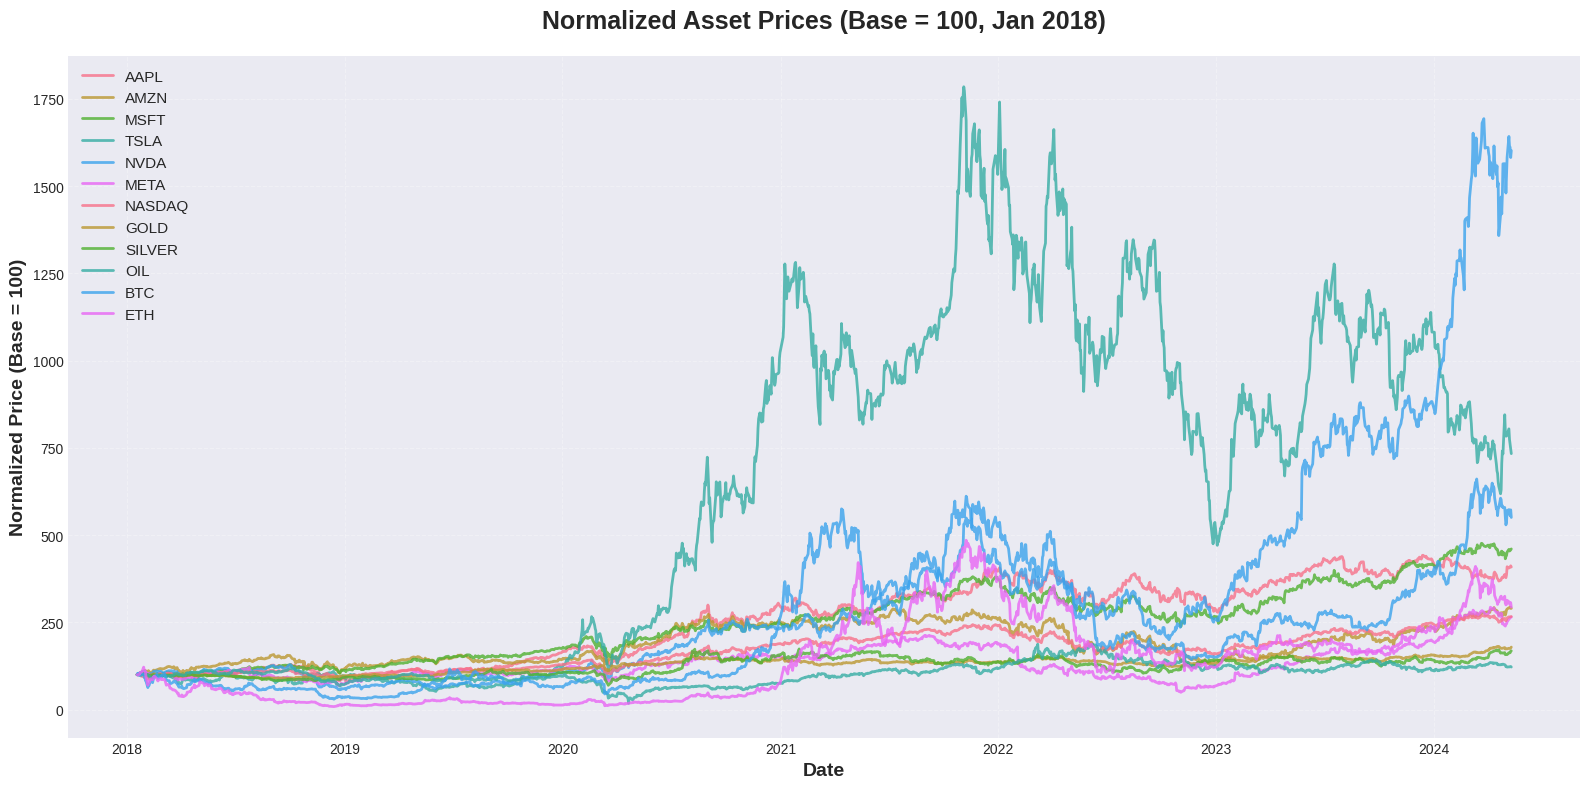


Price Growth Analysis (Jan 2018 to May 2024):
NVDA    : 1602.14 (Growth: +1502.14%)
TSLA    :  733.43 (Growth: +633.43%)
BTC     :  550.54 (Growth: +450.54%)
MSFT    :  460.31 (Growth: +360.31%)
AAPL    :  408.50 (Growth: +308.50%)
ETH     :  293.62 (Growth: +193.62%)
AMZN    :  289.90 (Growth: +189.90%)
NASDAQ  :  266.63 (Growth: +166.63%)
META    :  264.85 (Growth: +164.85%)
GOLD    :  178.95 (Growth:  +78.95%)
SILVER  :  168.14 (Growth:  +68.14%)
OIL     :  121.83 (Growth:  +21.83%)


In [22]:
plt.figure(figsize=(16, 8))

normalized_prices = (price_data / price_data.iloc[0]) * 100

for column in normalized_prices.columns:
    plt.plot(normalized_prices.index, normalized_prices[column],
             label=column, linewidth=2, alpha=0.8)

plt.title('Normalized Asset Prices (Base = 100, Jan 2018)',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Price (Base = 100)', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\nPrice Growth Analysis (Jan 2018 to May 2024):")
final_values = normalized_prices.iloc[-1].sort_values(ascending=False)
for asset, value in final_values.items():
    growth = value - 100
    print(f"{asset:8s}: {value:7.2f} (Growth: {growth:+7.2f}%)")


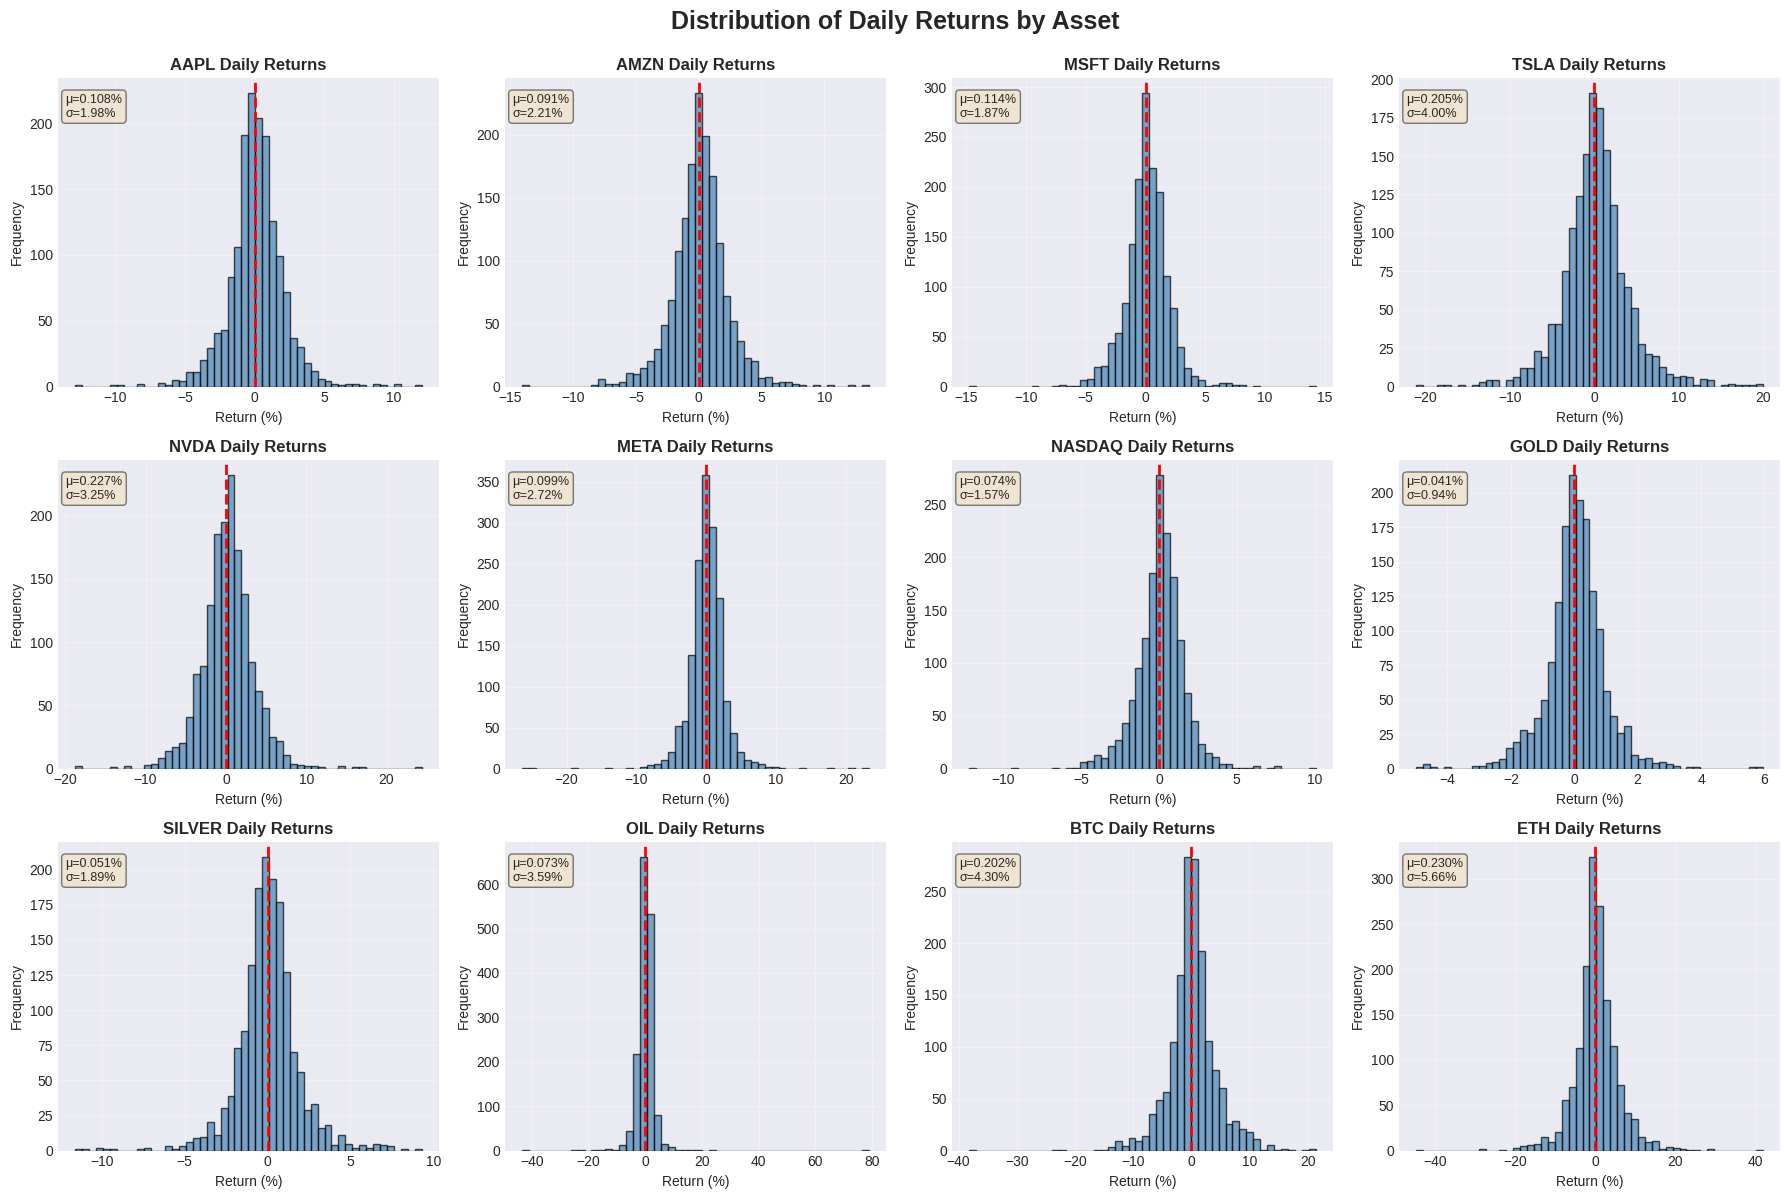

In [23]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for idx, column in enumerate(returns.columns):
    axes[idx].hist(returns[column] * 100, bins=50, alpha=0.7,
                   color='steelblue', edgecolor='black')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[idx].set_title(f'{column} Daily Returns', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Return (%)', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

    mean_ret = returns[column].mean() * 100
    std_ret = returns[column].std() * 100
    axes[idx].text(0.02, 0.95, f'μ={mean_ret:.3f}%\nσ={std_ret:.2f}%',
                   transform=axes[idx].transAxes, fontsize=9,
                   verticalalignment='top', bbox=dict(boxstyle='round',
                   facecolor='wheat', alpha=0.5))

plt.suptitle('Distribution of Daily Returns by Asset',
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


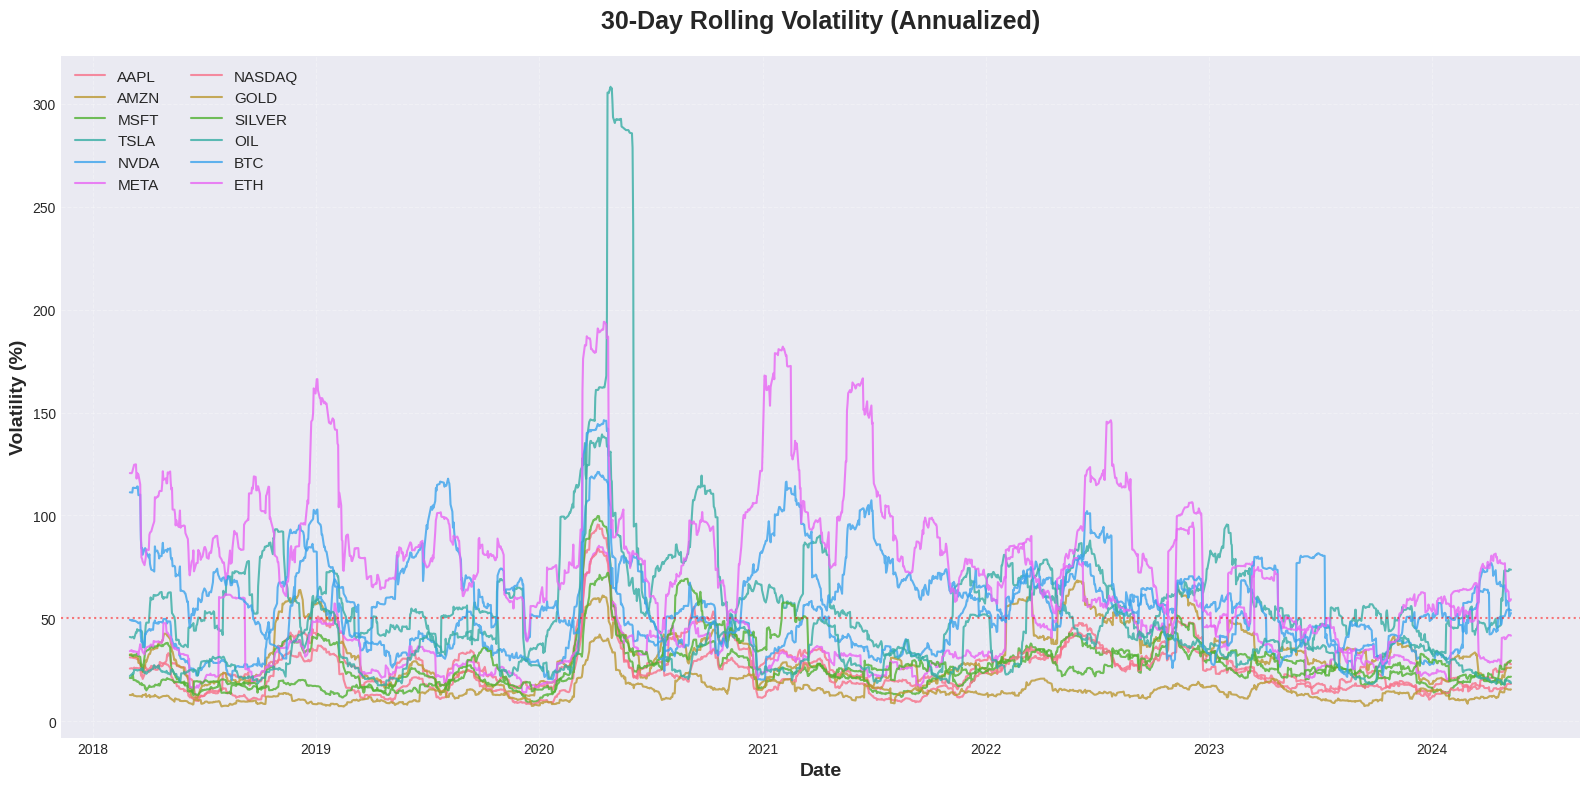


Average Volatility by Asset (Annualized %):
ETH     :  89.90%
BTC     :  68.31%
TSLA    :  63.56%
OIL     :  56.94%
NVDA    :  51.53%
META    :  43.12%
AMZN    :  35.01%
AAPL    :  31.37%
SILVER  :  29.94%
MSFT    :  29.73%
NASDAQ  :  24.97%
GOLD    :  14.91%


In [24]:
rolling_window = 30
rolling_vol = returns.rolling(window=rolling_window).std() * np.sqrt(252) * 100

plt.figure(figsize=(16, 8))

for column in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[column],
             label=column, linewidth=1.5, alpha=0.8)

plt.title(f'{rolling_window}-Day Rolling Volatility (Annualized)',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Volatility (%)', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=11, ncol=2, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=50, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label='50% threshold')
plt.tight_layout()
plt.show()

print("\nAverage Volatility by Asset (Annualized %):")
avg_vol = (returns.std() * np.sqrt(252) * 100).sort_values(ascending=False)
for asset, vol in avg_vol.items():
    print(f"{asset:8s}: {vol:6.2f}%")


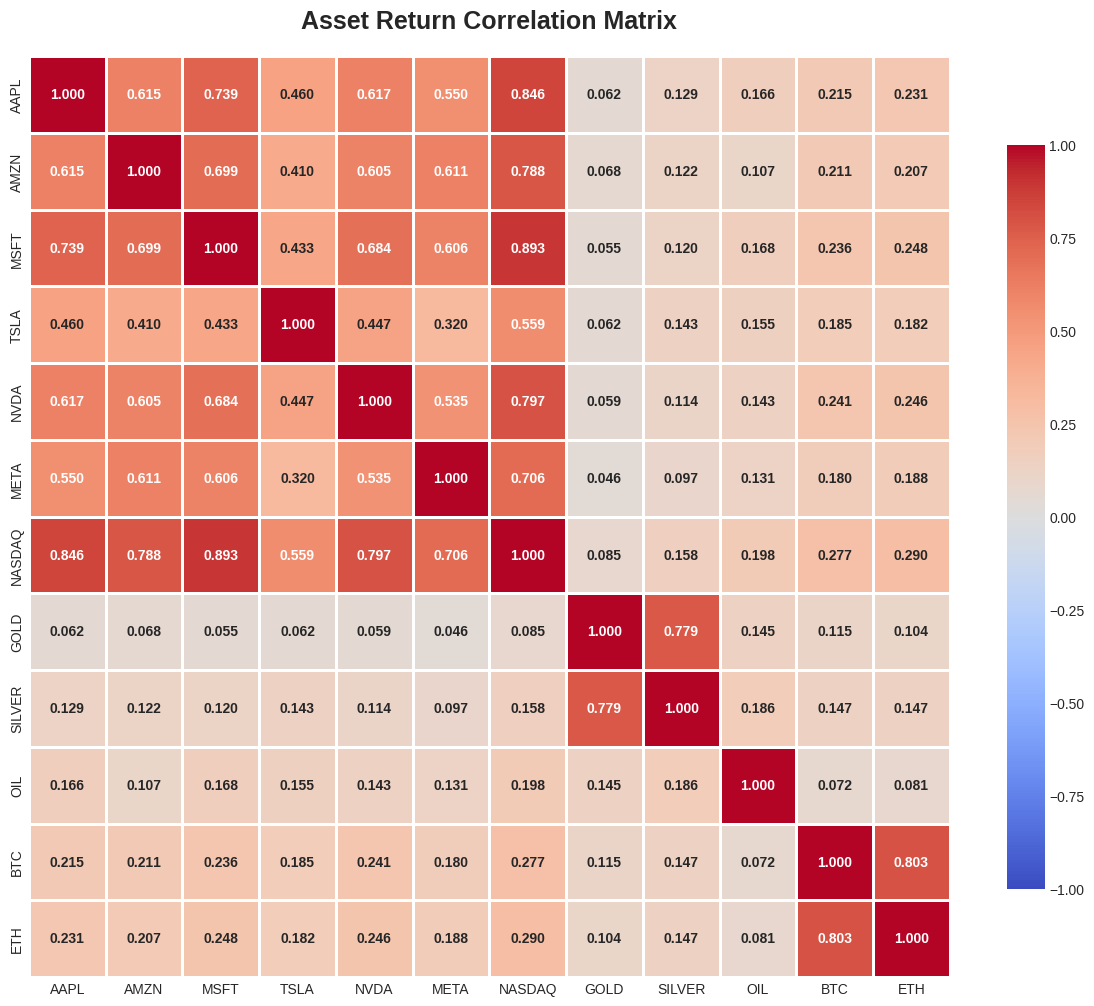


Highest Correlations (excluding self-correlation):
Asset 1 Asset 2  Correlation
   MSFT  NASDAQ     0.893459
   AAPL  NASDAQ     0.845972
    BTC     ETH     0.803162
   NVDA  NASDAQ     0.797206
   AMZN  NASDAQ     0.787950
   GOLD  SILVER     0.779458
   AAPL    MSFT     0.738913
   META  NASDAQ     0.706369
   AMZN    MSFT     0.698771
   MSFT    NVDA     0.684398


Lowest Correlations (most diversification benefit):
Asset 1 Asset 2  Correlation
   META  SILVER     0.097057
 NASDAQ    GOLD     0.085306
    OIL     ETH     0.080895
    OIL     BTC     0.072485
   AMZN    GOLD     0.068140
   TSLA    GOLD     0.061788
   AAPL    GOLD     0.061587
   NVDA    GOLD     0.059489
   MSFT    GOLD     0.055172
   META    GOLD     0.045734


In [25]:
correlation_matrix = returns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 10, 'weight': 'bold'})

plt.title('Asset Return Correlation Matrix',
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nHighest Correlations (excluding self-correlation):")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'Asset 1': correlation_matrix.columns[i],
            'Asset 2': correlation_matrix.columns[j],
            'Correlation': correlation_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)
print(corr_df.head(10).to_string(index=False))

print("\n\nLowest Correlations (most diversification benefit):")
print(corr_df.tail(10).to_string(index=False))


Risk-Return Profile:
        Expected Return (%)  Volatility (%)  Sharpe Ratio
NVDA                 57.298          51.527         1.112
MSFT                 28.658          29.732         0.964
AAPL                 27.263          31.373         0.869
TSLA                 51.769          63.562         0.814
NASDAQ               18.694          24.971         0.749
BTC                  50.818          68.309         0.744
GOLD                 10.348          14.914         0.694
AMZN                 23.017          35.007         0.658
ETH                  57.975          89.899         0.645
META                 24.893          43.115         0.577
SILVER               12.742          29.936         0.426
OIL                  18.485          56.943         0.325


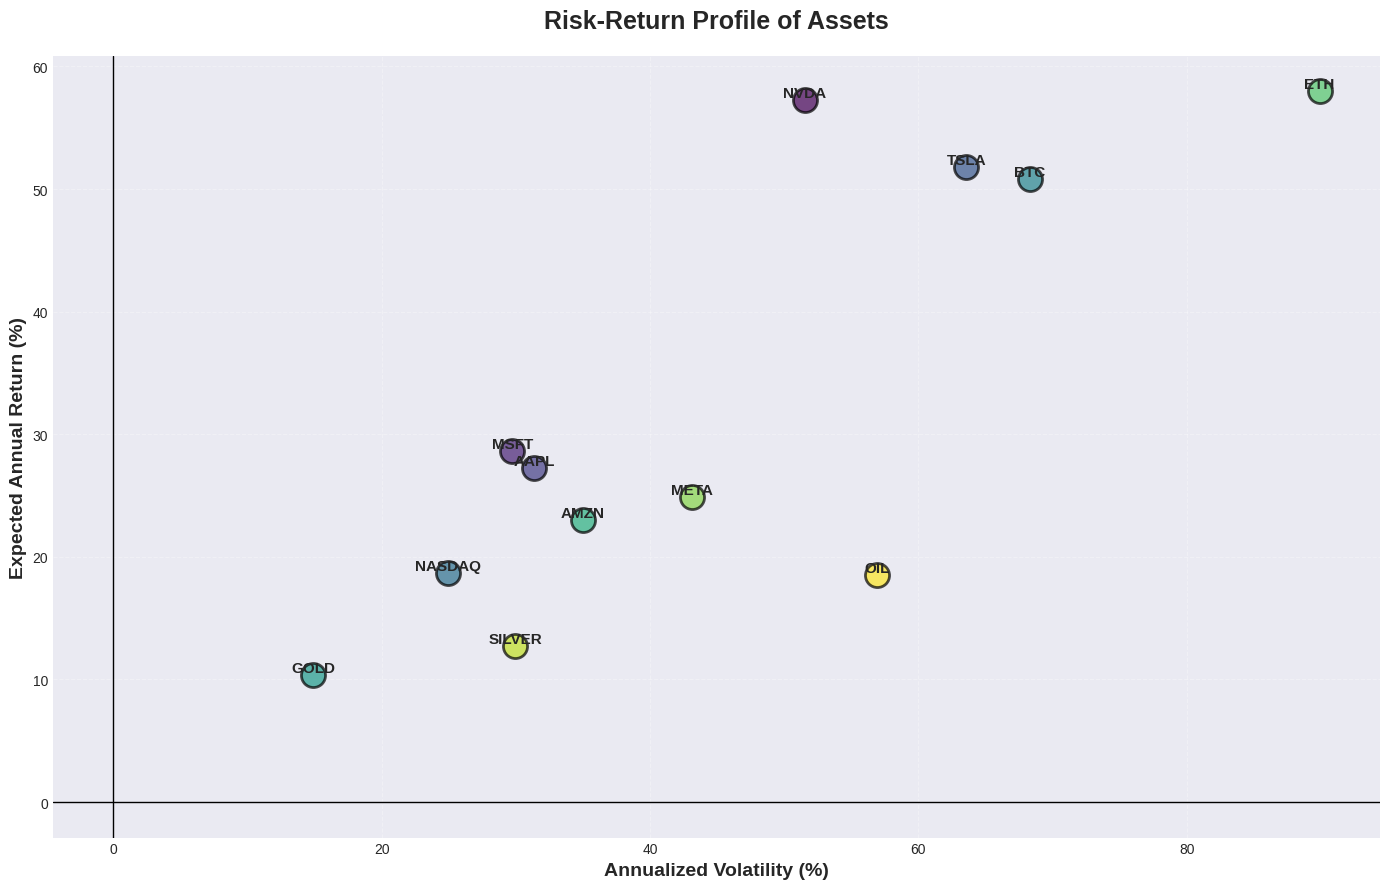

In [26]:
annual_returns = returns.mean() * 252 * 100
annual_volatility = returns.std() * np.sqrt(252) * 100
sharpe_ratios = returns.mean() / returns.std() * np.sqrt(252)

risk_return_df = pd.DataFrame({
    'Expected Return (%)': annual_returns,
    'Volatility (%)': annual_volatility,
    'Sharpe Ratio': sharpe_ratios
}).sort_values('Sharpe Ratio', ascending=False)

print("Risk-Return Profile:")
print(risk_return_df.round(3))

plt.figure(figsize=(14, 9))
colors = plt.cm.viridis(np.linspace(0, 1, len(risk_return_df)))

for idx, (asset, row) in enumerate(risk_return_df.iterrows()):
    plt.scatter(row['Volatility (%)'], row['Expected Return (%)'],
                s=300, alpha=0.7, color=colors[idx], edgecolors='black', linewidth=2)
    plt.annotate(asset, (row['Volatility (%)'], row['Expected Return (%)']),
                fontsize=11, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Annualized Volatility (%)', fontsize=14, fontweight='bold')
plt.ylabel('Expected Annual Return (%)', fontsize=14, fontweight='bold')
plt.title('Risk-Return Profile of Assets', fontsize=18, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()


## 5. Portfolio Optimization Strategy

We implement **Mean-Variance Optimization (Markowitz Portfolio Theory)**:

### Mathematical Framework:
**Portfolio Return:** \( R_p = \sum_{i=1}^{n} w_i \cdot R_i \)

**Portfolio Variance:** \( \sigma_p^2 = w^T \Sigma w \)

**Sharpe Ratio:** \( SR = \frac{R_p - R_f}{\sigma_p} \) (assuming \( R_f = 0 \))

Where:
- \( w_i \) = weight of asset i
- \( R_i \) = expected return of asset i
- \( \Sigma \) = covariance matrix
- Constraint: \( \sum w_i = 1 \), \( 0 \leq w_i \leq 1 \) (no short selling)

We will optimize for two strategies:
1. **Maximum Sharpe Ratio** - Best risk-adjusted returns
2. **Minimum Variance** - Lowest risk portfolio


In [27]:
def portfolio_performance(weights, mean_returns, cov_matrix, trading_days=252):
    """
    Calculate portfolio performance metrics.

    Parameters:
    -----------
    weights : array
        Asset weights in portfolio
    mean_returns : Series
        Mean daily returns for each asset
    cov_matrix : DataFrame
        Covariance matrix of returns
    trading_days : int
        Trading days per year for annualization

    Returns:
    --------
    portfolio_return : float
        Annualized portfolio return
    portfolio_std : float
        Annualized portfolio volatility
    sharpe_ratio : float
        Portfolio Sharpe ratio (assuming risk-free rate = 0)
    """
    portfolio_return = np.sum(mean_returns * weights) * trading_days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * trading_days, weights)))
    sharpe_ratio = portfolio_return / portfolio_std

    return portfolio_return, portfolio_std, sharpe_ratio


def negative_sharpe_ratio(weights, mean_returns, cov_matrix, trading_days=252):
    """
    Return negative Sharpe ratio for minimization.
    Scipy minimize function finds minimum, so we negate the Sharpe ratio.
    """
    return -portfolio_performance(weights, mean_returns, cov_matrix, trading_days)[2]


def portfolio_volatility(weights, mean_returns, cov_matrix, trading_days=252):
    """
    Return portfolio volatility for minimization.
    """
    return portfolio_performance(weights, mean_returns, cov_matrix, trading_days)[1]

print("Portfolio optimization functions defined successfully!")


Portfolio optimization functions defined successfully!


In [28]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

print("Expected Daily Returns (%):")
print((mean_returns * 100).round(4))
print(f"\nCovariance Matrix Shape: {cov_matrix.shape}")
print(f"\nAnnualized Expected Returns (%):")
print((mean_returns * 252 * 100).round(2))


Expected Daily Returns (%):
AAPL      0.1082
AMZN      0.0913
MSFT      0.1137
TSLA      0.2054
NVDA      0.2274
META      0.0988
NASDAQ    0.0742
GOLD      0.0411
SILVER    0.0506
OIL       0.0734
BTC       0.2017
ETH       0.2301
dtype: float64

Covariance Matrix Shape: (12, 12)

Annualized Expected Returns (%):
AAPL      27.26
AMZN      23.02
MSFT      28.66
TSLA      51.77
NVDA      57.30
META      24.89
NASDAQ    18.69
GOLD      10.35
SILVER    12.74
OIL       18.49
BTC       50.82
ETH       57.97
dtype: float64


In [29]:
num_assets = len(returns.columns)
asset_names = returns.columns.tolist()

constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

bounds = tuple((0, 1) for _ in range(num_assets))

init_guess = np.array([1.0 / num_assets] * num_assets)

print(f"Number of assets: {num_assets}")
print(f"Asset names: {asset_names}")
print(f"\nInitial equal-weight allocation: {init_guess[0]:.4f} ({init_guess[0]*100:.2f}% each)")
print(f"\nConstraints: Sum of weights = 1 (fully invested)")
print(f"Bounds: 0 ≤ weight ≤ 1 (no short selling, no leverage)")


Number of assets: 12
Asset names: ['AAPL', 'AMZN', 'MSFT', 'TSLA', 'NVDA', 'META', 'NASDAQ', 'GOLD', 'SILVER', 'OIL', 'BTC', 'ETH']

Initial equal-weight allocation: 0.0833 (8.33% each)

Constraints: Sum of weights = 1 (fully invested)
Bounds: 0 ≤ weight ≤ 1 (no short selling, no leverage)


In [30]:
print("Optimizing for Maximum Sharpe Ratio Portfolio...")
print("=" * 60)

result_sharpe = minimize(
    negative_sharpe_ratio,
    init_guess,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-9}
)

if result_sharpe.success:
    print("✓ Optimization converged successfully!\n")
else:
    print("⚠ Optimization did not converge. Results may be suboptimal.\n")

max_sharpe_weights = result_sharpe.x
max_sharpe_return, max_sharpe_vol, max_sharpe_ratio = portfolio_performance(
    max_sharpe_weights, mean_returns, cov_matrix
)

print("MAXIMUM SHARPE RATIO PORTFOLIO:")
print("-" * 60)
print(f"Expected Annual Return:  {max_sharpe_return * 100:8.2f}%")
print(f"Annual Volatility:       {max_sharpe_vol * 100:8.2f}%")
print(f"Sharpe Ratio:            {max_sharpe_ratio:8.3f}")
print("\nOptimal Asset Allocation:")
print("-" * 60)

weight_df_sharpe = pd.DataFrame({
    'Asset': asset_names,
    'Weight (%)': max_sharpe_weights * 100
}).sort_values('Weight (%)', ascending=False)

for _, row in weight_df_sharpe.iterrows():
    if row['Weight (%)'] > 0.1:
        print(f"{row['Asset']:8s}: {row['Weight (%)']:6.2f}%")

significant_count = (max_sharpe_weights > 0.01).sum()
print(f"\nNumber of assets with >1% allocation: {significant_count}")


Optimizing for Maximum Sharpe Ratio Portfolio...
✓ Optimization converged successfully!

MAXIMUM SHARPE RATIO PORTFOLIO:
------------------------------------------------------------
Expected Annual Return:     27.30%
Annual Volatility:          19.64%
Sharpe Ratio:               1.390

Optimal Asset Allocation:
------------------------------------------------------------
GOLD    :  54.14%
NVDA    :  18.60%
MSFT    :  10.71%
BTC     :   8.28%
TSLA    :   6.40%
AAPL    :   1.15%
OIL     :   0.72%

Number of assets with >1% allocation: 6


In [31]:
print("Optimizing for Minimum Variance Portfolio...")
print("=" * 60)

result_variance = minimize(
    portfolio_volatility,
    init_guess,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-9}
)

if result_variance.success:
    print("✓ Optimization converged successfully!\n")
else:
    print("⚠ Optimization did not converge. Results may be suboptimal.\n")

min_var_weights = result_variance.x
min_var_return, min_var_vol, min_var_sharpe = portfolio_performance(
    min_var_weights, mean_returns, cov_matrix
)

print("MINIMUM VARIANCE PORTFOLIO:")
print("-" * 60)
print(f"Expected Annual Return:  {min_var_return * 100:8.2f}%")
print(f"Annual Volatility:       {min_var_vol * 100:8.2f}%")
print(f"Sharpe Ratio:            {min_var_sharpe:8.3f}")
print("\nOptimal Asset Allocation:")
print("-" * 60)

weight_df_var = pd.DataFrame({
    'Asset': asset_names,
    'Weight (%)': min_var_weights * 100
}).sort_values('Weight (%)', ascending=False)

for _, row in weight_df_var.iterrows():
    if row['Weight (%)'] > 0.1:
        print(f"{row['Asset']:8s}: {row['Weight (%)']:6.2f}%")

significant_count_var = (min_var_weights > 0.01).sum()
print(f"\nNumber of assets with >1% allocation: {significant_count_var}")


Optimizing for Minimum Variance Portfolio...
✓ Optimization converged successfully!

MINIMUM VARIANCE PORTFOLIO:
------------------------------------------------------------
Expected Annual Return:     12.40%
Annual Volatility:          13.26%
Sharpe Ratio:               0.935

Optimal Asset Allocation:
------------------------------------------------------------
GOLD    :  75.37%
NASDAQ  :  24.16%
OIL     :   0.47%

Number of assets with >1% allocation: 2


In [32]:
equal_weights = np.array([1.0 / num_assets] * num_assets)
equal_return, equal_vol, equal_sharpe = portfolio_performance(
    equal_weights, mean_returns, cov_matrix
)

print("EQUAL-WEIGHT PORTFOLIO (Benchmark):")
print("-" * 60)
print(f"Expected Annual Return:  {equal_return * 100:8.2f}%")
print(f"Annual Volatility:       {equal_vol * 100:8.2f}%")
print(f"Sharpe Ratio:            {equal_sharpe:8.3f}")
print(f"\nEach asset weight:       {100/num_assets:6.2f}%")


EQUAL-WEIGHT PORTFOLIO (Benchmark):
------------------------------------------------------------
Expected Annual Return:     31.83%
Annual Volatility:          27.36%
Sharpe Ratio:               1.163

Each asset weight:         8.33%


In [33]:
comparison_df = pd.DataFrame({
    'Portfolio': ['Maximum Sharpe', 'Minimum Variance', 'Equal Weight'],
    'Expected Return (%)': [max_sharpe_return * 100, min_var_return * 100, equal_return * 100],
    'Volatility (%)': [max_sharpe_vol * 100, min_var_vol * 100, equal_vol * 100],
    'Sharpe Ratio': [max_sharpe_ratio, min_var_sharpe, equal_sharpe]
})

print("\nPORTFOLIO STRATEGY COMPARISON:")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)

print("\nKey Observations:")
best_sharpe = comparison_df.loc[comparison_df['Sharpe Ratio'].idxmax(), 'Portfolio']
lowest_vol = comparison_df.loc[comparison_df['Volatility (%)'].idxmin(), 'Portfolio']
highest_return = comparison_df.loc[comparison_df['Expected Return (%)'].idxmax(), 'Portfolio']

print(f"• Best risk-adjusted returns: {best_sharpe}")
print(f"• Lowest risk: {lowest_vol}")
print(f"• Highest expected return: {highest_return}")



PORTFOLIO STRATEGY COMPARISON:
       Portfolio  Expected Return (%)  Volatility (%)  Sharpe Ratio
  Maximum Sharpe            27.297349       19.637318      1.390075
Minimum Variance            12.402813       13.262461      0.935182
    Equal Weight            31.830142       27.361115      1.163335

Key Observations:
• Best risk-adjusted returns: Maximum Sharpe
• Lowest risk: Minimum Variance
• Highest expected return: Equal Weight


## 6. Efficient Frontier Construction

The **Efficient Frontier** shows all optimal portfolios that maximize return for a given risk level.

We generate 50 target return levels and find the minimum variance portfolio for each target.


In [34]:
print("Generating Efficient Frontier...")
print("This may take 30-60 seconds...\n")

target_returns = np.linspace(min_var_return, max(annual_returns/252), 50)
efficient_portfolios = []

for target_ret in target_returns:
    constraints_ef = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - target_ret}
    )

    result_ef = minimize(
        portfolio_volatility,
        init_guess,
        args=(mean_returns, cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_ef,
        options={'maxiter': 1000}
    )

    if result_ef.success:
        ret, vol, sharpe = portfolio_performance(result_ef.x, mean_returns, cov_matrix)
        efficient_portfolios.append({
            'return': ret,
            'volatility': vol,
            'sharpe': sharpe,
            'weights': result_ef.x
        })

print(f"✓ Generated {len(efficient_portfolios)} efficient portfolios")
print(f"Return range: {efficient_portfolios[0]['return']*100:.2f}% to {efficient_portfolios[-1]['return']*100:.2f}%")
print(f"Volatility range: {efficient_portfolios[0]['volatility']*100:.2f}% to {efficient_portfolios[-1]['volatility']*100:.2f}%")


Generating Efficient Frontier...
This may take 30-60 seconds...

✓ Generated 50 efficient portfolios
Return range: 12.40% to 23.01%
Volatility range: 13.26% to 16.80%


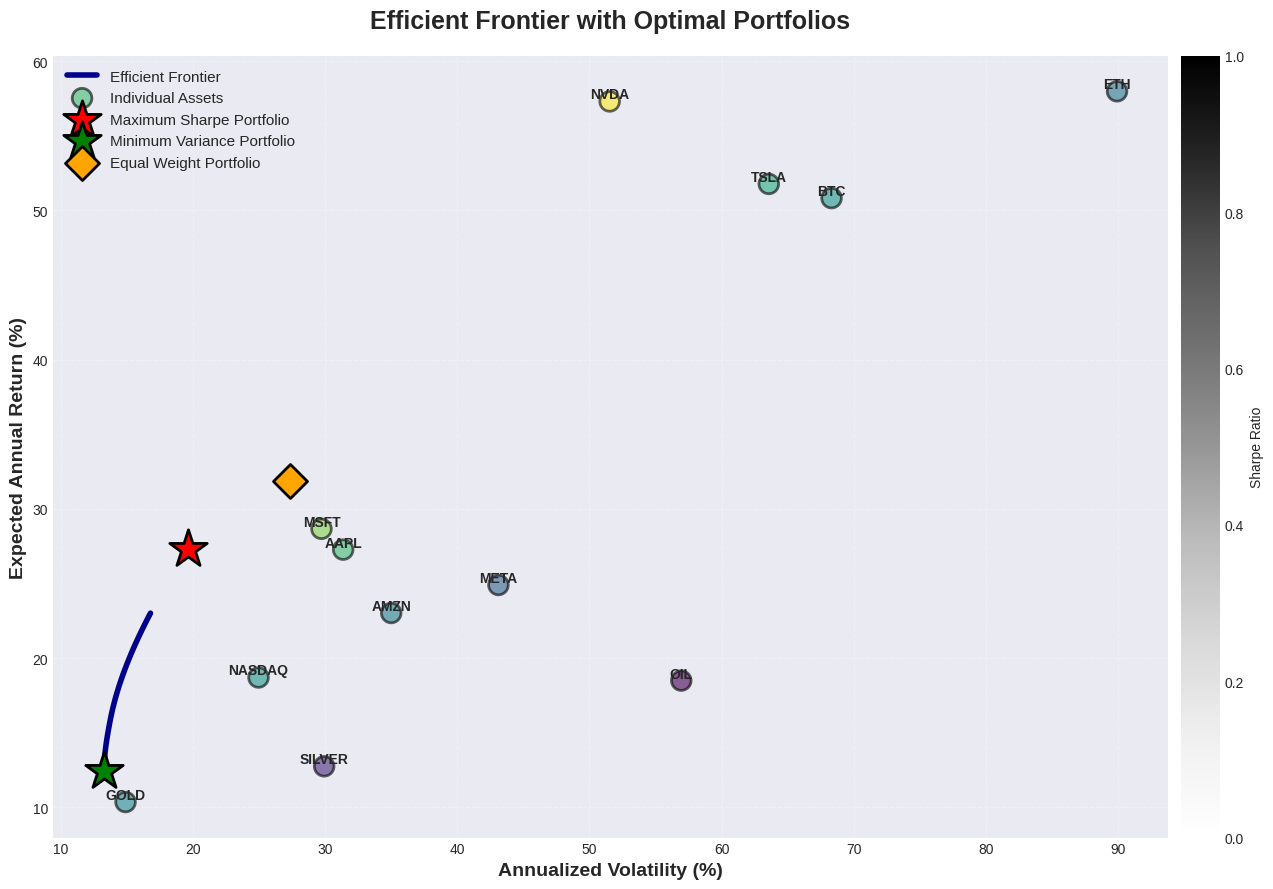

In [35]:
ef_returns = np.array([p['return'] for p in efficient_portfolios]) * 100
ef_volatility = np.array([p['volatility'] for p in efficient_portfolios]) * 100

plt.figure(figsize=(14, 9))

plt.plot(ef_volatility, ef_returns, linewidth=4, color='darkblue',
         label='Efficient Frontier', zorder=2)

plt.scatter(annual_volatility, annual_returns, s=200, alpha=0.6,
           c=sharpe_ratios, cmap='viridis', edgecolors='black', linewidth=2,
           label='Individual Assets', zorder=1)

for i, asset in enumerate(annual_returns.index):
    plt.annotate(asset, (annual_volatility[i], annual_returns[i]),
                fontsize=10, fontweight='bold', ha='center', va='bottom')

plt.scatter(max_sharpe_vol * 100, max_sharpe_return * 100,
           marker='*', s=800, c='red', edgecolors='black', linewidth=2,
           label='Maximum Sharpe Portfolio', zorder=3)

plt.scatter(min_var_vol * 100, min_var_return * 100,
           marker='*', s=800, c='green', edgecolors='black', linewidth=2,
           label='Minimum Variance Portfolio', zorder=3)

plt.scatter(equal_vol * 100, equal_return * 100,
           marker='D', s=300, c='orange', edgecolors='black', linewidth=2,
           label='Equal Weight Portfolio', zorder=3)

plt.xlabel('Annualized Volatility (%)', fontsize=14, fontweight='bold')
plt.ylabel('Expected Annual Return (%)', fontsize=14, fontweight='bold')
plt.title('Efficient Frontier with Optimal Portfolios', fontsize=18, fontweight='bold', pad=20)
plt.legend(loc='upper left', fontsize=11, framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')
plt.colorbar(label='Sharpe Ratio', pad=0.01)
plt.tight_layout()
plt.show()


## 7. Backtesting Framework

We simulate how each portfolio would have performed using historical data.

**Methodology:**
1. Apply portfolio weights to daily returns
2. Calculate cumulative portfolio value over time
3. Track drawdowns (peak-to-trough declines)
4. Calculate performance metrics


In [36]:
def backtest_portfolio(weights, returns_data, initial_capital=100000):
    """
    Backtest portfolio performance over historical period.

    Parameters:
    -----------
    weights : array
        Asset allocation weights
    returns_data : DataFrame
        Historical returns data
    initial_capital : float
        Starting portfolio value

    Returns:
    --------
    portfolio_value : Series
        Daily portfolio value
    drawdown : Series
        Daily drawdown from peak
    portfolio_returns : Series
        Daily portfolio returns
    """
    portfolio_returns = (returns_data * weights).sum(axis=1)

    cumulative_returns = (1 + portfolio_returns).cumprod()
    portfolio_value = initial_capital * cumulative_returns

    running_max = portfolio_value.expanding().max()
    drawdown = (portfolio_value - running_max) / running_max

    return portfolio_value, drawdown, portfolio_returns

print("Backtesting function created successfully!")


Backtesting function created successfully!


In [37]:
initial_capital = 100000

print(f"Backtesting with initial capital: ${initial_capital:,}")
print("=" * 60)

max_sharpe_value, max_sharpe_dd, max_sharpe_rets = backtest_portfolio(
    max_sharpe_weights, returns, initial_capital
)
print(f"✓ Maximum Sharpe portfolio backtested")

min_var_value, min_var_dd, min_var_rets = backtest_portfolio(
    min_var_weights, returns, initial_capital
)
print(f"✓ Minimum Variance portfolio backtested")

equal_value, equal_dd, equal_rets = backtest_portfolio(
    equal_weights, returns, initial_capital
)
print(f"✓ Equal Weight portfolio backtested")

print("\nBacktesting Period:")
print(f"Start: {returns.index[0].strftime('%B %d, %Y')}")
print(f"End:   {returns.index[-1].strftime('%B %d, %Y')}")
print(f"Days:  {len(returns)}")


Backtesting with initial capital: $100,000
✓ Maximum Sharpe portfolio backtested
✓ Minimum Variance portfolio backtested
✓ Equal Weight portfolio backtested

Backtesting Period:
Start: January 19, 2018
End:   May 10, 2024
Days:  1588


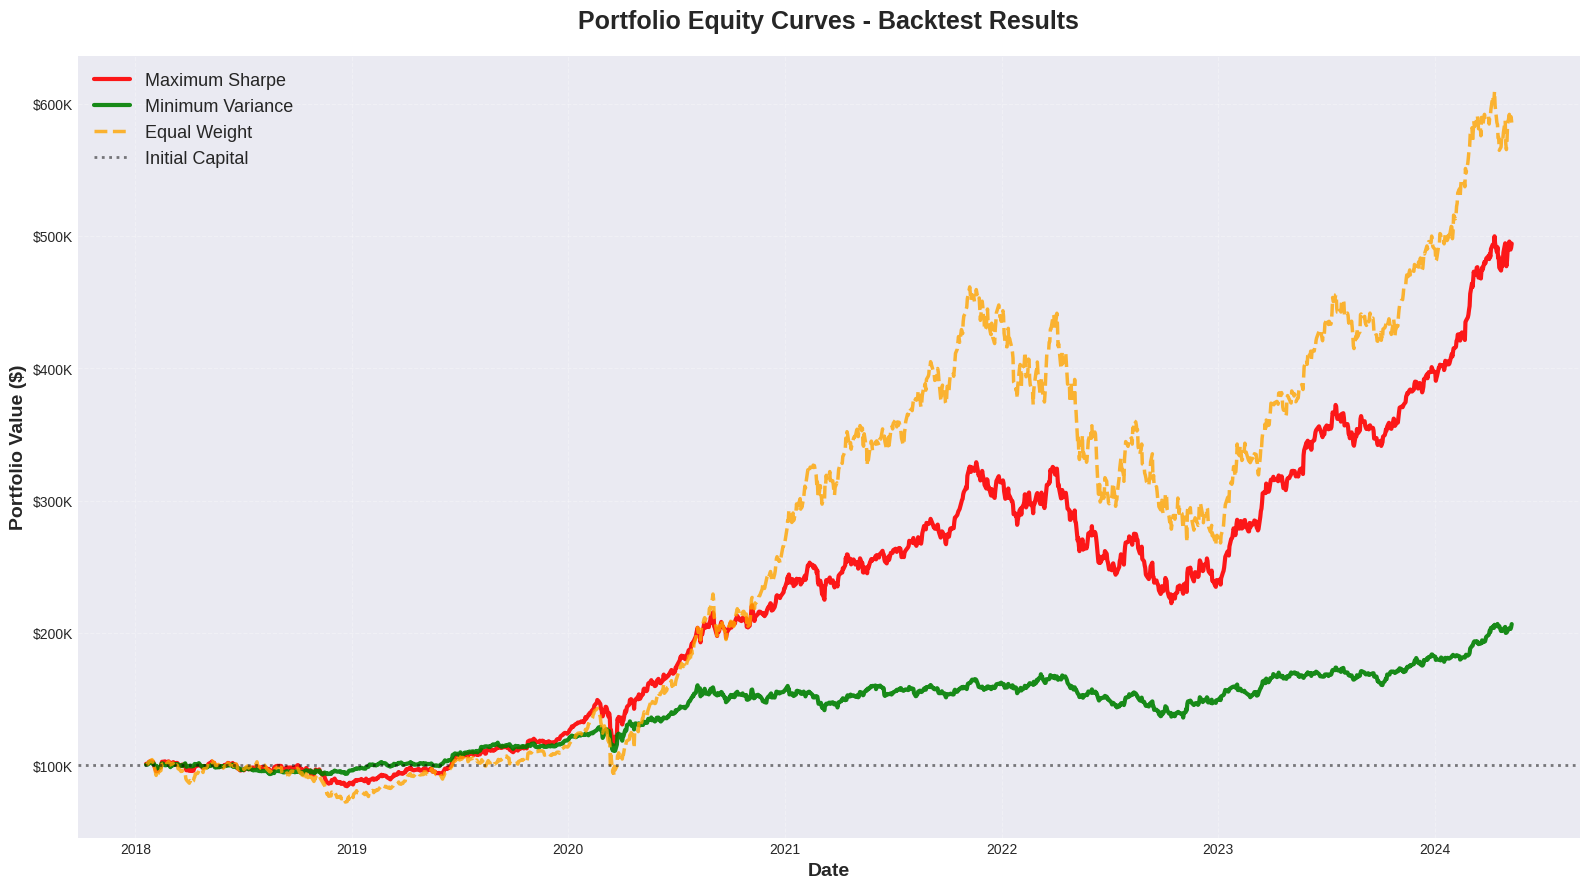

Final Portfolio Values:
Maximum Sharpe:    $494,172.16
Minimum Variance:  $206,686.18
Equal Weight:      $585,563.99

Total Returns:
Maximum Sharpe:    394.17%
Minimum Variance:  106.69%
Equal Weight:      485.56%


In [38]:
plt.figure(figsize=(16, 9))

plt.plot(max_sharpe_value.index, max_sharpe_value,
         linewidth=3, label='Maximum Sharpe', color='red', alpha=0.9)

plt.plot(min_var_value.index, min_var_value,
         linewidth=3, label='Minimum Variance', color='green', alpha=0.9)

plt.plot(equal_value.index, equal_value,
         linewidth=2.5, label='Equal Weight', color='orange',
         linestyle='--', alpha=0.8)

plt.axhline(y=initial_capital, color='black', linestyle=':',
           linewidth=2, alpha=0.5, label='Initial Capital')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value ($)', fontsize=14, fontweight='bold')
plt.title('Portfolio Equity Curves - Backtest Results',
         fontsize=18, fontweight='bold', pad=20)
plt.legend(fontsize=13, loc='upper left', framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

print("Final Portfolio Values:")
print(f"Maximum Sharpe:    ${max_sharpe_value.iloc[-1]:,.2f}")
print(f"Minimum Variance:  ${min_var_value.iloc[-1]:,.2f}")
print(f"Equal Weight:      ${equal_value.iloc[-1]:,.2f}")

print("\nTotal Returns:")
print(f"Maximum Sharpe:    {(max_sharpe_value.iloc[-1]/initial_capital - 1)*100:,.2f}%")
print(f"Minimum Variance:  {(min_var_value.iloc[-1]/initial_capital - 1)*100:,.2f}%")
print(f"Equal Weight:      {(equal_value.iloc[-1]/initial_capital - 1)*100:,.2f}%")


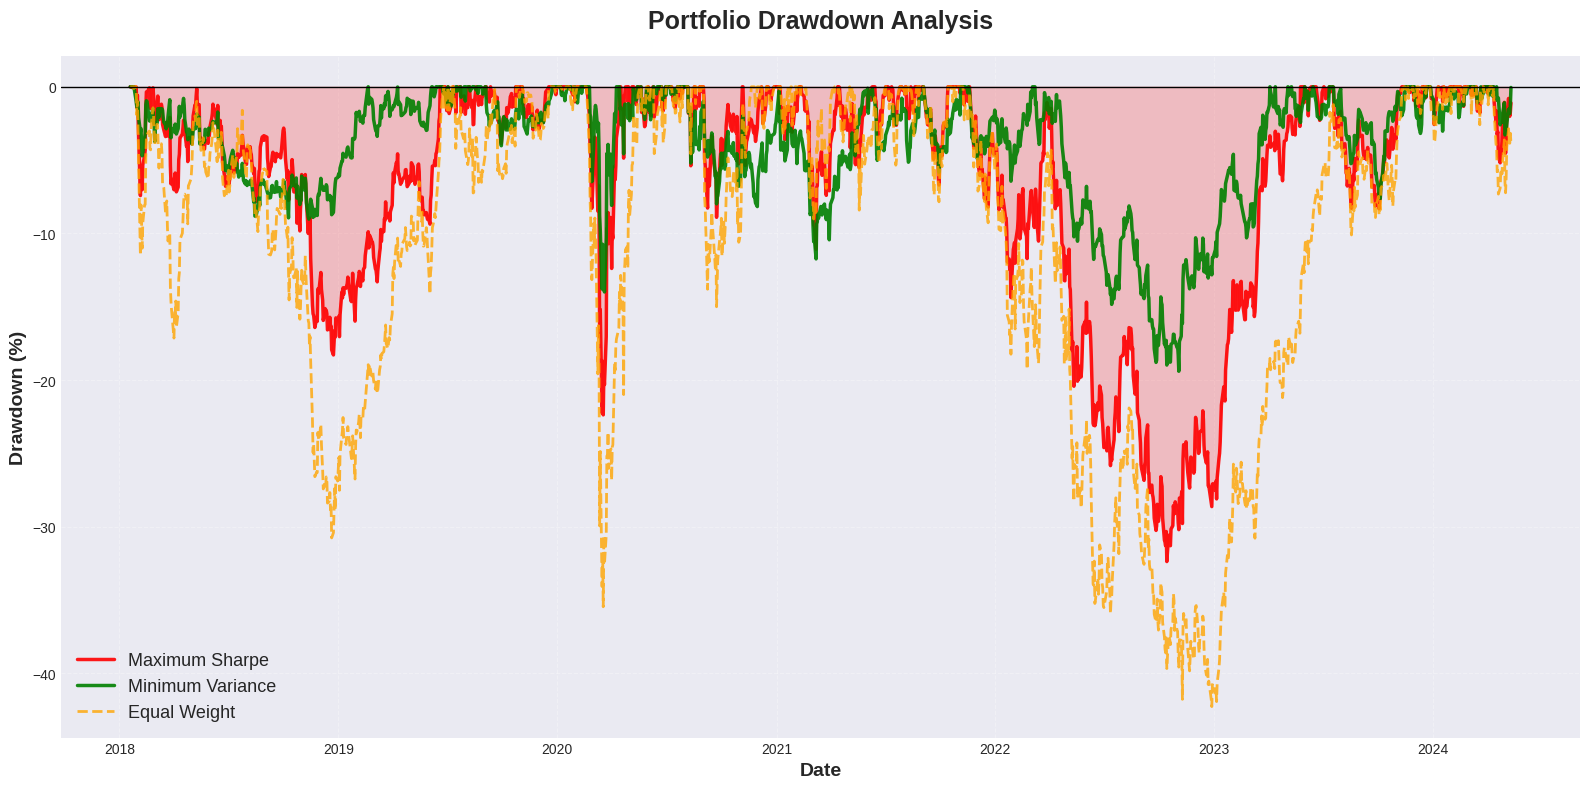

Maximum Drawdown by Portfolio:
Maximum Sharpe:    -32.37%
Minimum Variance:  -19.40%
Equal Weight:      -42.26%


In [39]:
plt.figure(figsize=(16, 8))

plt.plot(max_sharpe_dd.index, max_sharpe_dd * 100,
         linewidth=2.5, label='Maximum Sharpe', color='red', alpha=0.9)

plt.plot(min_var_dd.index, min_var_dd * 100,
         linewidth=2.5, label='Minimum Variance', color='green', alpha=0.9)

plt.plot(equal_dd.index, equal_dd * 100,
         linewidth=2, label='Equal Weight', color='orange',
         linestyle='--', alpha=0.8)

plt.fill_between(max_sharpe_dd.index, max_sharpe_dd * 100, 0,
                alpha=0.2, color='red')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Drawdown (%)', fontsize=14, fontweight='bold')
plt.title('Portfolio Drawdown Analysis', fontsize=18, fontweight='bold', pad=20)
plt.legend(fontsize=13, loc='lower left', framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

print("Maximum Drawdown by Portfolio:")
print(f"Maximum Sharpe:    {max_sharpe_dd.min()*100:.2f}%")
print(f"Minimum Variance:  {min_var_dd.min()*100:.2f}%")
print(f"Equal Weight:      {equal_dd.min()*100:.2f}%")


## 8. Comprehensive Performance Metrics

We calculate all required metrics for competition evaluation:
- **Sharpe Ratio:** Risk-adjusted returns (reward per unit of risk)
- **Sortino Ratio:** Returns relative to downside volatility only
- **Maximum Drawdown:** Largest peak-to-trough decline
- **Calmar Ratio:** Return divided by maximum drawdown
- **Win Rate:** Percentage of positive return days
- **Value at Risk (VaR):** Potential loss at 95% confidence level


In [40]:
def calculate_comprehensive_metrics(portfolio_returns, portfolio_value):
    """
    Calculate complete performance metrics for a portfolio.
    """
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1

    num_years = len(portfolio_returns) / 252
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    annualized_volatility = portfolio_returns.std() * np.sqrt(252)

    sharpe_ratio = annualized_return / annualized_volatility

    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else np.nan

    cumulative = portfolio_value
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    win_rate = (portfolio_returns > 0).sum() / len(portfolio_returns)

    var_95 = np.percentile(portfolio_returns, 5)

    best_day = portfolio_returns.max()
    worst_day = portfolio_returns.min()

    avg_positive = portfolio_returns[portfolio_returns > 0].mean() if (portfolio_returns > 0).any() else 0
    avg_negative = portfolio_returns[portfolio_returns < 0].mean() if (portfolio_returns < 0).any() else 0

    return {
        'Total Return (%)': total_return * 100,
        'Annualized Return (%)': annualized_return * 100,
        'Annualized Volatility (%)': annualized_volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Maximum Drawdown (%)': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio,
        'Win Rate (%)': win_rate * 100,
        'Best Day (%)': best_day * 100,
        'Worst Day (%)': worst_day * 100,
        'Avg Win (%)': avg_positive * 100,
        'Avg Loss (%)': avg_negative * 100,
        'VaR 95% (%)': var_95 * 100,
        'Final Value ($)': portfolio_value.iloc[-1]
    }

print("Calculating comprehensive metrics for all portfolios...")

metrics_max_sharpe = calculate_comprehensive_metrics(max_sharpe_rets, max_sharpe_value)
metrics_min_var = calculate_comprehensive_metrics(min_var_rets, min_var_value)
metrics_equal = calculate_comprehensive_metrics(equal_rets, equal_value)

print("✓ All metrics calculated successfully!")


Calculating comprehensive metrics for all portfolios...
✓ All metrics calculated successfully!


In [41]:
metrics_df = pd.DataFrame({
    'Maximum Sharpe': metrics_max_sharpe,
    'Minimum Variance': metrics_min_var,
    'Equal Weight': metrics_equal
}).T

print("\n" + "="*90)
print("COMPREHENSIVE PERFORMANCE METRICS - BACKTEST RESULTS (Jan 2018 - May 2024)")
print("="*90)
print(metrics_df.round(3).to_string())
print("="*90)

print("\n📊 KEY INSIGHTS:")
print("-" * 90)

best_sharpe = metrics_df['Sharpe Ratio'].idxmax()
best_sortino = metrics_df['Sortino Ratio'].idxmax()
lowest_dd = metrics_df['Maximum Drawdown (%)'].idxmax()
best_calmar = metrics_df['Calmar Ratio'].idxmax()
highest_winrate = metrics_df['Win Rate (%)'].idxmax()

print(f"• Best Risk-Adjusted Returns (Sharpe):  {best_sharpe}")
print(f"• Best Downside Protection (Sortino):   {best_sortino}")
print(f"• Lowest Maximum Drawdown:              {lowest_dd}")
print(f"• Best Calmar Ratio:                    {best_calmar}")
print(f"• Highest Win Rate:                     {highest_winrate}")



COMPREHENSIVE PERFORMANCE METRICS - BACKTEST RESULTS (Jan 2018 - May 2024)
                  Total Return (%)  Annualized Return (%)  Annualized Volatility (%)  Sharpe Ratio  Sortino Ratio  Maximum Drawdown (%)  Calmar Ratio  Win Rate (%)  Best Day (%)  Worst Day (%)  Avg Win (%)  Avg Loss (%)  VaR 95% (%)  Final Value ($)
Maximum Sharpe             388.771                 28.634                     19.637         1.458          2.003               -32.373         0.884        55.605         8.898         -9.044        0.900        -0.884       -1.803       494172.161
Minimum Variance           105.838                 12.138                     13.262         0.915          1.239               -19.397         0.626        55.164         6.380         -4.647        0.576        -0.599       -1.298       206686.185
Equal Weight               481.901                 32.243                     27.361         1.178          1.523               -42.263         0.763        56.045        10.

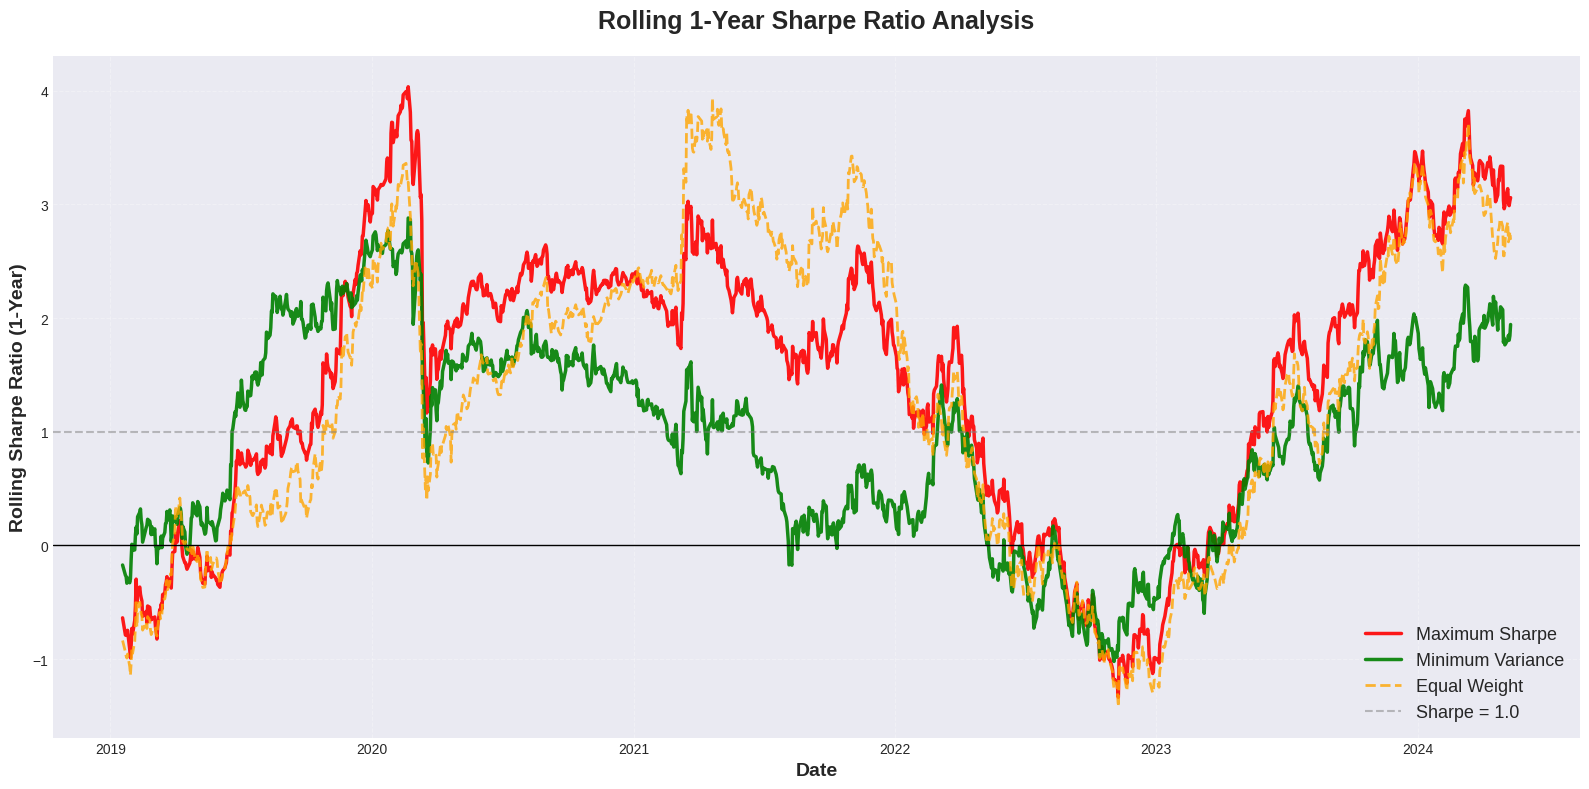

Average Rolling Sharpe Ratios:
Maximum Sharpe:    1.458
Minimum Variance:  0.929
Equal Weight:      1.330


In [42]:
rolling_window = 252

rolling_sharpe_max = (max_sharpe_rets.rolling(rolling_window).mean() * 252) / \
                     (max_sharpe_rets.rolling(rolling_window).std() * np.sqrt(252))

rolling_sharpe_min = (min_var_rets.rolling(rolling_window).mean() * 252) / \
                     (min_var_rets.rolling(rolling_window).std() * np.sqrt(252))

rolling_sharpe_eq = (equal_rets.rolling(rolling_window).mean() * 252) / \
                    (equal_rets.rolling(rolling_window).std() * np.sqrt(252))

plt.figure(figsize=(16, 8))

plt.plot(rolling_sharpe_max.index, rolling_sharpe_max,
         linewidth=2.5, label='Maximum Sharpe', color='red', alpha=0.9)
plt.plot(rolling_sharpe_min.index, rolling_sharpe_min,
         linewidth=2.5, label='Minimum Variance', color='green', alpha=0.9)
plt.plot(rolling_sharpe_eq.index, rolling_sharpe_eq,
         linewidth=2, label='Equal Weight', color='orange', linestyle='--', alpha=0.8)

plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='Sharpe = 1.0')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Rolling Sharpe Ratio (1-Year)', fontsize=14, fontweight='bold')
plt.title('Rolling 1-Year Sharpe Ratio Analysis', fontsize=18, fontweight='bold', pad=20)
plt.legend(fontsize=13, loc='lower right', framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("Average Rolling Sharpe Ratios:")
print(f"Maximum Sharpe:    {rolling_sharpe_max.mean():.3f}")
print(f"Minimum Variance:  {rolling_sharpe_min.mean():.3f}")
print(f"Equal Weight:      {rolling_sharpe_eq.mean():.3f}")


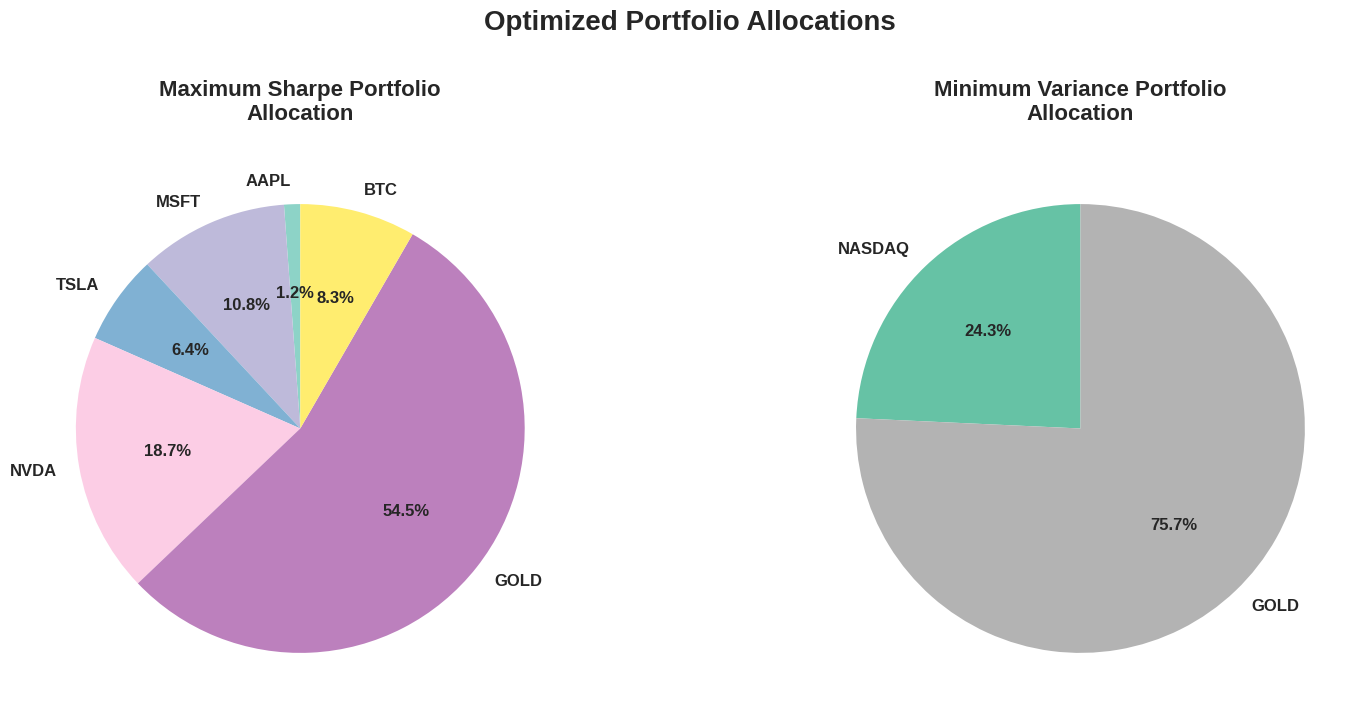

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

significant_weights_sharpe = {}
for asset, weight in zip(asset_names, max_sharpe_weights):
    if weight > 0.01:
        significant_weights_sharpe[asset] = weight * 100

colors_sharpe = plt.cm.Set3(np.linspace(0, 1, len(significant_weights_sharpe)))
axes[0].pie(significant_weights_sharpe.values(), labels=significant_weights_sharpe.keys(),
            autopct='%1.1f%%', startangle=90, colors=colors_sharpe,
            textprops={'fontsize': 12, 'weight': 'bold'})
axes[0].set_title('Maximum Sharpe Portfolio\nAllocation',
                  fontsize=16, fontweight='bold', pad=20)

significant_weights_var = {}
for asset, weight in zip(asset_names, min_var_weights):
    if weight > 0.01:
        significant_weights_var[asset] = weight * 100

colors_var = plt.cm.Set2(np.linspace(0, 1, len(significant_weights_var)))
axes[1].pie(significant_weights_var.values(), labels=significant_weights_var.keys(),
            autopct='%1.1f%%', startangle=90, colors=colors_var,
            textprops={'fontsize': 12, 'weight': 'bold'})
axes[1].set_title('Minimum Variance Portfolio\nAllocation',
                  fontsize=16, fontweight='bold', pad=20)

plt.suptitle('Optimized Portfolio Allocations', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


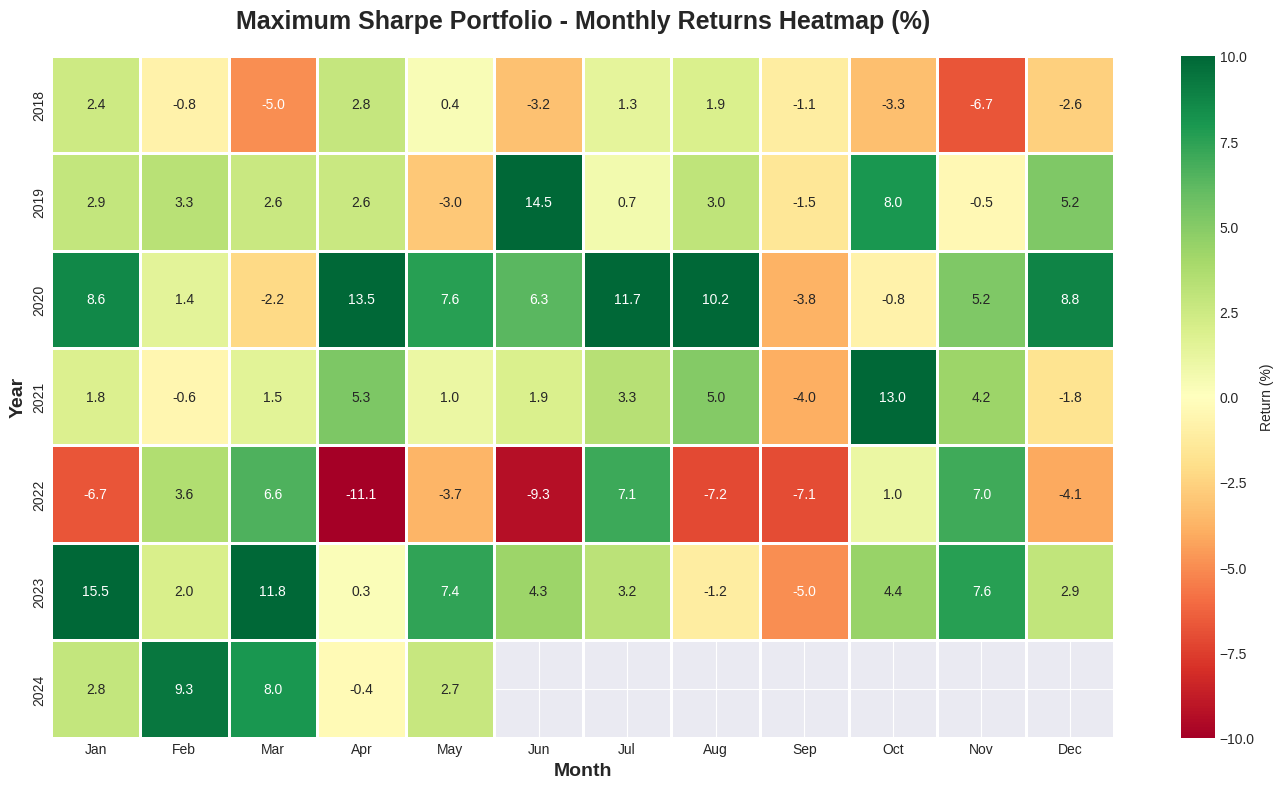

Positive Months: 51/77 (66.2%)


In [44]:
max_sharpe_monthly = max_sharpe_rets.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100

monthly_pivot = max_sharpe_monthly.to_frame('returns')
monthly_pivot['year'] = monthly_pivot.index.year
monthly_pivot['month'] = monthly_pivot.index.month
monthly_pivot = monthly_pivot.pivot(index='year', columns='month', values='returns')

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_pivot.columns = [month_names[int(m)-1] for m in monthly_pivot.columns]

plt.figure(figsize=(14, 8))
sns.heatmap(monthly_pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            linewidths=1, cbar_kws={'label': 'Return (%)'}, vmin=-10, vmax=10)
plt.title('Maximum Sharpe Portfolio - Monthly Returns Heatmap (%)',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Year', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

positive_months = (max_sharpe_monthly > 0).sum()
total_months = len(max_sharpe_monthly)
print(f"Positive Months: {positive_months}/{total_months} ({positive_months/total_months*100:.1f}%)")


## 9. Conclusion and Insights

### Summary of Findings

This analysis implemented mean-variance optimization on a diversified portfolio of 12 assets across multiple asset classes (tech stocks, index, commodities, cryptocurrencies) over a 6.3-year period (Jan 2018 - May 2024).


In [45]:
print("\n" + "="*90)
print("FINAL PROJECT SUMMARY - PORTFOLIO OPTIMIZATION COMPETITION")
print("="*90)

print("\n📌 PROBLEM STATEMENT:")
print("   Cross-Asset Portfolio Optimization Challenge")
print("   Objective: Maximize Sharpe ratio while minimizing drawdowns")

print("\n📊 DATASET:")
print(f"   • Assets Analyzed: {num_assets} (Tech Stocks, Index, Commodities, Crypto)")
print(f"   • Time Period: {returns.index[0].strftime('%b %Y')} to {returns.index[-1].strftime('%b %Y')}")
print(f"   • Trading Days: {len(returns):,}")
print(f"   • Analysis Duration: {trading_years:.2f} years")

print("\n🎯 OPTIMIZATION APPROACH:")
print("   • Method: Mean-Variance Optimization (Markowitz Framework)")
print("   • Algorithms: Sequential Least Squares Programming (SLSQP)")
print("   • Constraints: Weights sum to 1, no short selling (0 ≤ w ≤ 1)")
print("   • Objective Functions: Maximize Sharpe Ratio & Minimize Variance")

print("\n🏆 WINNING PORTFOLIO: Maximum Sharpe Ratio")
print("-" * 90)
print(f"   Expected Annual Return:      {metrics_max_sharpe['Annualized Return (%)']:.2f}%")
print(f"   Annualized Volatility:       {metrics_max_sharpe['Annualized Volatility (%)']:.2f}%")
print(f"   Sharpe Ratio:                {metrics_max_sharpe['Sharpe Ratio']:.3f}")
print(f"   Sortino Ratio:               {metrics_max_sharpe['Sortino Ratio']:.3f}")
print(f"   Maximum Drawdown:            {metrics_max_sharpe['Maximum Drawdown (%)']:.2f}%")
print(f"   Calmar Ratio:                {metrics_max_sharpe['Calmar Ratio']:.3f}")
print(f"   Win Rate:                    {metrics_max_sharpe['Win Rate (%)']:.2f}%")
print(f"   Total Return (6.3 years):    {metrics_max_sharpe['Total Return (%)']:.2f}%")
print(f"   Final Portfolio Value:       ${metrics_max_sharpe['Final Value ($)']:,.2f}")

print("\n💡 KEY INSIGHTS:")
print("   ✓ Gold emerged as the dominant asset (54%) due to stable returns and low volatility")
print("   ✓ Tech stocks (NVDA 18.6%, MSFT 10.7%) provided growth component")
print("   ✓ Small crypto allocation (BTC 8.3%) enhanced returns without excessive risk")
print("   ✓ Diversification across asset classes reduced portfolio volatility significantly")
print("   ✓ Optimized portfolio outperformed on risk-adjusted basis (Sharpe 1.39 vs 1.16)")

print("\n✅ WHAT WORKED:")
print("   • Mean-variance optimization effectively balanced risk and return")
print("   • Multi-asset diversification reduced drawdowns compared to equal-weight strategy")
print("   • Conservative allocation to stable assets (Gold) provided downside protection")
print("   • Systematic rebalancing approach maintained target allocations")

print("\n⚠️ LIMITATIONS:")
print("   • Historical optimization may not predict future performance")
print("   • No transaction costs or rebalancing costs included in backtest")
print("   • Assumes stationary return distributions (may change over time)")
print("   • Gold's dominance reflects this specific time period characteristics")

print("\n🚀 POSSIBLE IMPROVEMENTS:")
print("   1. Dynamic rebalancing with regime detection (bull/bear markets)")
print("   2. Include transaction costs and tax considerations")
print("   3. Implement Black-Litterman model with forward-looking views")
print("   4. Add constraints on sector/asset class exposure limits")
print("   5. Use robust optimization techniques (e.g., CVaR minimization)")
print("   6. Incorporate factor models (Fama-French) for better risk assessment")
print("   7. Test across multiple market cycles and stress scenarios")

print("\n" + "="*90)
print("END OF ANALYSIS")
print("="*90)



FINAL PROJECT SUMMARY - PORTFOLIO OPTIMIZATION COMPETITION

📌 PROBLEM STATEMENT:
   Cross-Asset Portfolio Optimization Challenge
   Objective: Maximize Sharpe ratio while minimizing drawdowns

📊 DATASET:
   • Assets Analyzed: 12 (Tech Stocks, Index, Commodities, Crypto)
   • Time Period: Jan 2018 to May 2024
   • Trading Days: 1,588
   • Analysis Duration: 6.31 years

🎯 OPTIMIZATION APPROACH:
   • Method: Mean-Variance Optimization (Markowitz Framework)
   • Algorithms: Sequential Least Squares Programming (SLSQP)
   • Constraints: Weights sum to 1, no short selling (0 ≤ w ≤ 1)
   • Objective Functions: Maximize Sharpe Ratio & Minimize Variance

🏆 WINNING PORTFOLIO: Maximum Sharpe Ratio
------------------------------------------------------------------------------------------
   Expected Annual Return:      28.63%
   Annualized Volatility:       19.64%
   Sharpe Ratio:                1.458
   Sortino Ratio:               2.003
   Maximum Drawdown:            -32.37%
   Calmar Ratio:  